Author: Ashley Stewart

Original paper: https://onlinelibrary.wiley.com/doi/10.1002/mrm.29048

<a href="https://hub.play-sydney.neurodesk.org/user/neurodesk-example-notebooks-rfz9zzrf/lab/workspaces/auto-q/tree/qsmxt_example.ipynb" target="_parent"><img src="https://img.shields.io/badge/launch-binder-579aca.svg?logo=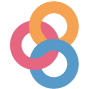" alt="Open In Binder"/>  </a>
<a href="https://colab.research.google.com/github/iishiishii/example-notebooks/blob/main/qsmxt_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>   </a>

## Setup Neurodesk

In [1]:
%%capture
import os
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  os.environ["LD_PRELOAD"] = "";
  os.environ["APPTAINER_BINDPATH"] = "/content"
  os.environ["MPLCONFIGDIR"] = "/content/matplotlib-mpldir"
  os.environ["LMOD_CMD"] = "/usr/share/lmod/lmod/libexec/lmod"

  !curl -J -O https://raw.githubusercontent.com/NeuroDesk/neurocommand/main/googlecolab_setup.sh
  !chmod +x googlecolab_setup.sh
  !./googlecolab_setup.sh

  os.environ["MODULEPATH"] = ':'.join(map(str, list(map(lambda x: os.path.join(os.path.abspath('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/'), x),os.listdir('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/')))))


# QSMxT Interactive Notebook

This interactive notebook estimates Quantitative Susceptibility Maps (QSMs) for two gradient-echo (GRE) MRI acquisitions using [QSMxT](https://github.com/QSMxT/QSMxT) provided by the [Neurodesk](https://neurodesk.org) project.

## What is QSM?

QSM is a form of quantitative MRI (qMRI) that estimates the magnetic susceptibility distribution across an imaged object. Magnetic susceptibility is the degree to which a material becomes magnetised by an external magnetic field. Major contributors to susceptibility include iron, calcium, and myelin, with the susceptibility of water typically approximating a zero-reference, though it is slightly diamagnetic. Read more about QSM [here](https://doi.org/10.1002/mrm.25358).

## What is QSMxT?

[QSMxT](https://github.com/QSMxT/QSMxT) is a suite of tools for building and running automated pipelines for QSM that:

- is available open-source without any licensing required;
- is distributed as a software container making it straightforward to access and install (Neurodesk!)
- scales its processing to execute across many acquisitions through jobs parallelisation (using multiple processors or HPCs) provided by [Nipype](https://nipype.readthedocs.io);
- automates steps that usually require manual intervention and scripting, including:
  - DICOM to [BIDS](https://bids-specification.readthedocs.io/en/stable/index.html) conversion;
  - QSM reconstruction using a range of algorithms;
  - segmentation using [FastSurfer](https://github.com/Deep-MI/FastSurfer);
  - group space generation using [ANTs](https://github.com/ANTsX/ANTs);
  - export of susceptibility statistics by subject and region of interest (ROI) to CSV.

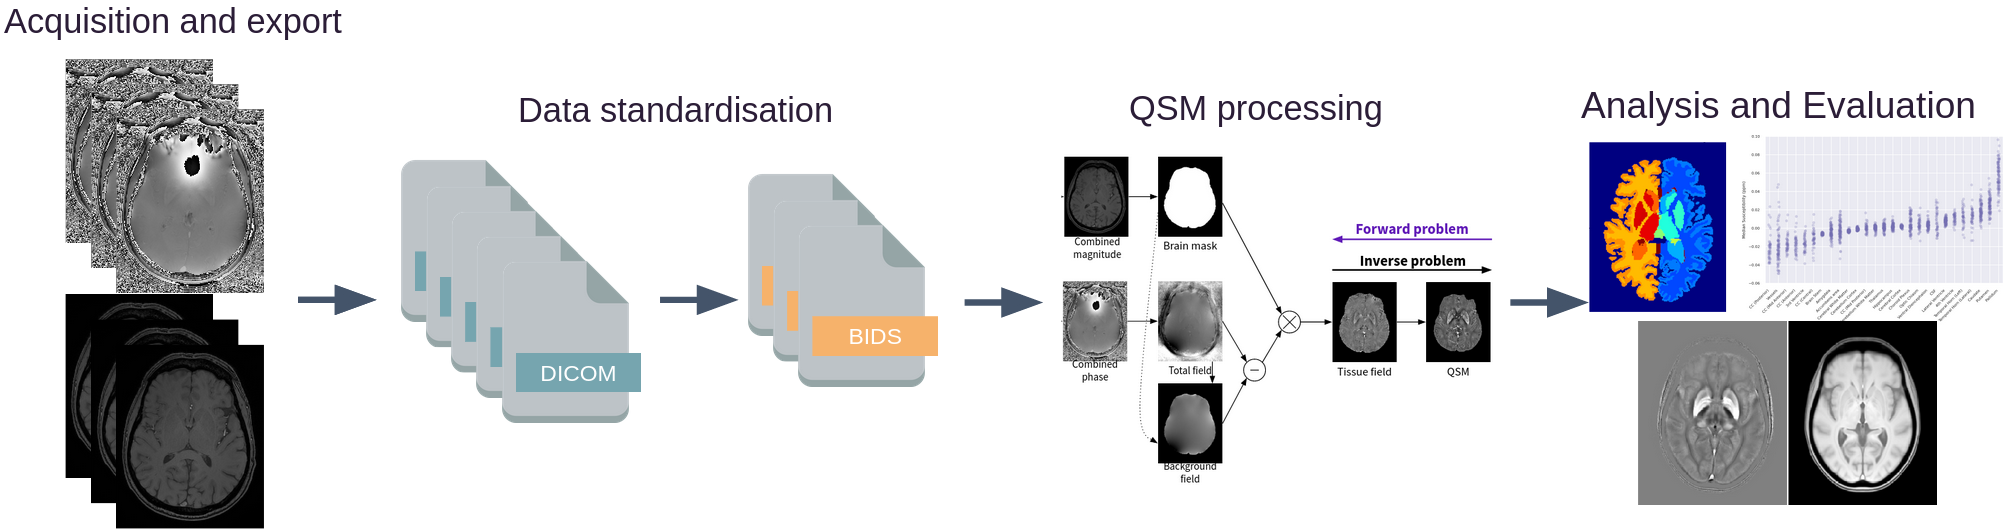

## How do I access QSMxT?

There are a few ways you can access QSMxT:

 - **This notebook**: You can access QSMxT in this notebook right now!
   - If you are running this on a Neurodesk Play instance, you can upload your own data into the sidebar via drag-and-drop.
 - **Neurodesktop**: QSMxT is in the applications menu of Neurodesktop.
   - On Neurodesk Play, upload your own data into the desktop via drag-and-drop.
   - On a local install of Neurodesk, bring any necessary files into the shared `~/neurodesktop-storage` directory
 - **Local install**: QSMxT can also be installed via the [Docker container](https://github.com/QSMxT/QSMxT#installation)
 - **HPC install**: QSMxT can also be installed via the [Singularity container](https://github.com/QSMxT/QSMxT#installation) for use on HPCs

# Download example DICOMs

Here, we download some example DICOMs from our OSF repository for QSMxT.

These data include GRE and T1-weighted acquisitions for one subject (duplicated to act as two subjects).

In [18]:
!pip install osfclient
!osf -p ru43c clone . > /dev/null 2>&1
!tar xf osfstorage/dicoms-unsorted.tar
!rm -rf osfstorage/
!tree dicoms-unsorted | head
!echo -e "...\nThere are `ls dicoms-unsorted | wc -l` unsorted DICOMs in ./dicoms-unsorted/"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
dicoms-unsorted
├── MR.1.100.dcm
├── MR.1.101.dcm
├── MR.1.102.dcm
├── MR.1.103.dcm
├── MR.1.104.dcm
├── MR.1.105.dcm
├── MR.1.106.dcm
├── MR.1.107.dcm
├── MR.1.108.dcm
...
There are 1216 unsorted DICOMs in ./dicoms-unsorted/


# Load QSMxT

To load QSMxT inside a notebook, we can use the available module system:

In [19]:
import lmod
await lmod.load('qsmxt/1.3.5')
!qsmxt_version.py

v1.3.5 (commit date: Sat Feb 25 22:06:42 2023 +1000) (container version qsmxt_1.3.5_20230227.simg (singularity))


# Data standardisation

QSMxT requires input data to conform to the [Brain Imaging Data Structure (BIDS)](https://bids.neuroimaging.io/).

Luckily, QSMxT also provides scripts that can convert unorganised NIfTI or DICOM images to BIDS.

## Sort DICOMs

Before we can convert DICOMs to BIDS cleanly, we need to sort the DICOMs by subject, session and series.

We can sort the DICOMs using `run_0_dicomSort.py`.

Note that this script relies on accurate DICOM header information. If your data is sorted incorrectly, you may need to manually correct the sorting, or sort the files yourself. Be sure to follow the folder structure shown below.

In [20]:
!run_0_dicomSort.py dicoms-unsorted dicoms-sorted

INFO: Running QSMxT v1.3.5 (commit date: Sat Feb 25 22:06:42 2023 +1000)
INFO: Command: /opt/QSMxT/run_0_dicomSort.py dicoms-unsorted dicoms-sorted
INFO: Python interpreter: /opt/miniconda-4.7.12.1/bin/python3
INFO: Reading file list...
INFO: 1216 DICOM files found.
INFO: Sorting DICOMs in /content/dicoms-sorted...
INFO: Identified subject: 1
INFO: Identified session: 1 #1 20170705
INFO: Identified series: sub-1/ses-1/6_mp2rage_highres_0p5iso_slab
INFO: Identified session: 2 #1 20170705
INFO: Identified series: sub-2/ses-1/6_mp2rage_highres_0p5iso_slab
INFO: Identified series: sub-2/ses-1/6_qsm_p2_1mmiso_te20
INFO: Identified series: sub-1/ses-1/6_qsm_p2_1mmiso_te20
INFO: Identified series: sub-1/ses-1/5_qsm_p2_1mmiso_te20
INFO: Identified series: sub-2/ses-1/5_qsm_p2_1mmiso_te20
INFO: Warnings occurred!
INFO: Finished


Now we can see clearly that there are two subjects, each with one session, each with three DICOM series:

In [21]:
!tree dicoms-sorted -L 3

dicoms-sorted
├── log_2023-06-01_00-23-33690405.txt
├── log_2023-06-01_00-48-39367139.txt
├── references.txt
├── sub-1
│   └── ses-1
│       ├── 5_qsm_p2_1mmiso_te20
│       ├── 6_mp2rage_highres_0p5iso_slab
│       └── 6_qsm_p2_1mmiso_te20
└── sub-2
    └── ses-1
        ├── 5_qsm_p2_1mmiso_te20
        ├── 6_mp2rage_highres_0p5iso_slab
        └── 6_qsm_p2_1mmiso_te20

10 directories, 3 files


## Convert to BIDS

Now that the DICOMs are sorted, we can convert to BIDS using `run_1_dicomConvert.py`.

The DICOM to BIDS conversion must identify which series should be used for QSM reconstruction (T2*-weighted), and which series should be used for segmentation (T1-weighted). Because this information is not stored in the DICOM header, the user must provide it, or QSMxT can make a guess based on the `ProtocolName` field. By default, QSMxT assumes series matching any of the patterns in `['*qsm*', '*t2starw*']` are to be used for QSM, and series matching the pattern `['*t1w*']` are to be used for segmentation. If series cannot be identified, the user must do so. At minimum, at least one QSM series must be identified.

If QSMxT is run interactively, the user will be prompted to identify the relevant series'. However, because we are running QSMxT in a notebook, we disable the interactivity using `--auto_yes` and provide the missing information using command-line arguments (`--t1w_protocol_patterns` and `--t2starw_protocol_patterns`). In this case, the T1-weighted scan requires identification, so we pass `--t2starw_protocol_patterns "*mp2rage*"`:

In [22]:
!run_1_dicomConvert.py dicoms-sorted bids \
    --t1w_protocol_patterns "*mp2rage*" \
    --auto_yes

INFO: Running QSMxT v1.3.5 (commit date: Sat Feb 25 22:06:42 2023 +1000)
INFO: Command: /opt/QSMxT/run_1_dicomConvert.py dicoms-sorted bids --t1w_protocol_patterns *mp2rage* --auto_yes
INFO: Python interpreter: /opt/miniconda-4.7.12.1/bin/python3
INFO: Converting all DICOMs to NIfTI...
INFO: Running command: 'dcm2niix -z n -o "/content/bids/sub-1/ses-1/extra_data" "/content/dicoms-sorted/sub-1/ses-1/5_qsm_p2_1mmiso_te20" >> "/content/bids/sub-1/ses-1/extra_data/dcm2niix_output.txt"'
INFO: Running command: 'dcm2niix -z n -o "/content/bids/sub-1/ses-1/extra_data" "/content/dicoms-sorted/sub-1/ses-1/6_mp2rage_highres_0p5iso_slab" >> "/content/bids/sub-1/ses-1/extra_data/dcm2niix_output.txt"'
INFO: Running command: 'dcm2niix -z n -o "/content/bids/sub-1/ses-1/extra_data" "/content/dicoms-sorted/sub-1/ses-1/6_qsm_p2_1mmiso_te20" >> "/content/bids/sub-1/ses-1/extra_data/dcm2niix_output.txt"'
INFO: Running command: 'dcm2niix -z n -o "/content/bids/sub-2/ses-1/extra_data" "/content/dicoms-sort

In [23]:
!tree bids

bids
├── dataset_description.json
├── log_2023-06-01_00-23-48663428.txt
├── log_2023-06-01_00-48-50578158.txt
├── README
├── references.txt
├── sub-1
│   └── ses-1
│       ├── anat
│       │   ├── sub-1_ses-1_run-01_part-mag_T2starw.json
│       │   ├── sub-1_ses-1_run-01_part-mag_T2starw.nii
│       │   ├── sub-1_ses-1_run-01_part-phase_T2starw.json
│       │   ├── sub-1_ses-1_run-01_part-phase_T2starw.nii
│       │   ├── sub-1_ses-1_run-01_T1w.json
│       │   └── sub-1_ses-1_run-01_T1w.nii
│       └── extra_data
│           └── dcm2niix_output.txt
└── sub-2
    └── ses-1
        ├── anat
        │   ├── sub-2_ses-1_run-01_part-mag_T2starw.json
        │   ├── sub-2_ses-1_run-01_part-mag_T2starw.nii
        │   ├── sub-2_ses-1_run-01_part-phase_T2starw.json
        │   ├── sub-2_ses-1_run-01_part-phase_T2starw.nii
        │   ├── sub-2_ses-1_run-01_T1w.json
        │   └── sub-2_ses-1_run-01_T1w.nii
        └── extra_data
            └── dcm2niix_output.txt

8 directories, 19 files


# Inspect input data

Here we define a function we will use to visualise NIfTI images so we can view some of the input data:

In [24]:
def show_nii(nii_path, title=None, cmap='gray', **imshow_args):
    from matplotlib import pyplot as plt
    import numpy as np
    import nibabel as nib
    import glob

    # load data
    data_1 = nib.load(nii_path).get_fdata()

    # get middle slices
    slc_data1 = np.rot90(data_1[np.shape(data_1)[0]//2,:,:])
    slc_data2 = np.rot90(data_1[:,np.shape(data_1)[1]//2,:])
    slc_data3 = np.rot90(data_1[:,:,np.shape(data_1)[2]//2])

    # show slices
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8,10))
    if title: plt.suptitle(title)

    axes[0].imshow(slc_data1, cmap=cmap, **imshow_args)
    axes[1].imshow(slc_data2, cmap=cmap, **imshow_args)
    axes[2].imshow(slc_data3, cmap=cmap, **imshow_args)

    axes[0].axis('off')
    axes[1].axis('off')
    axes[2].axis('off')

    fig.tight_layout()
    fig.subplots_adjust(top=1.55)
    plt.show()

In [25]:
from glob import glob

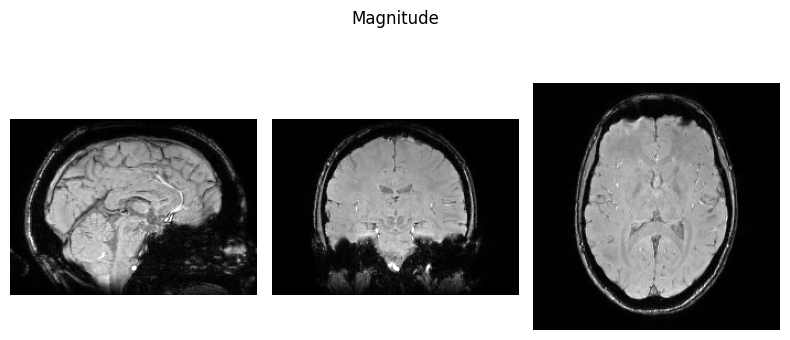

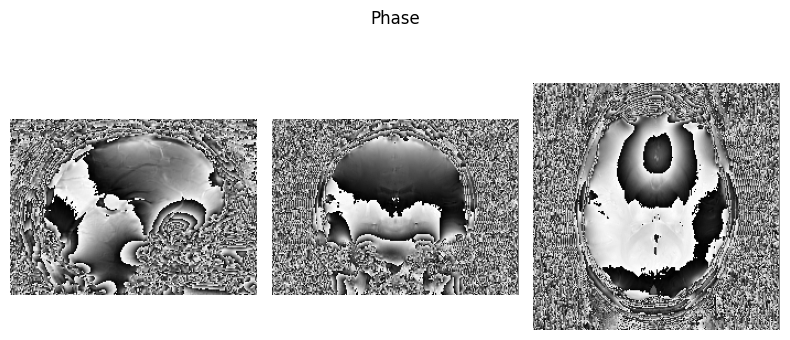

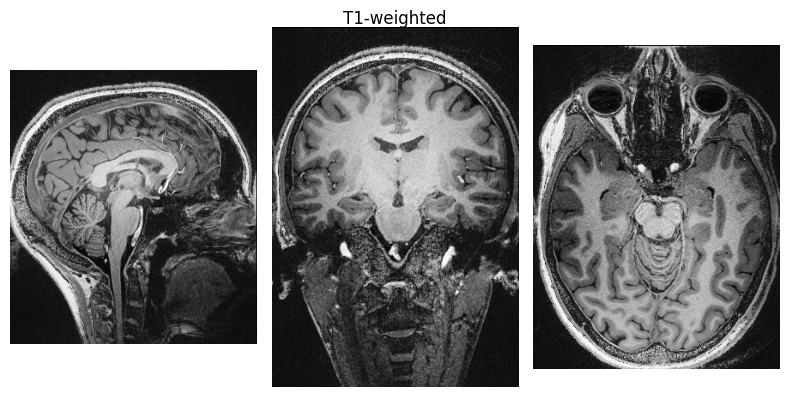

In [26]:
show_nii(glob("bids/sub-*/ses-*/anat/*mag*T2starw*nii*")[0], title="Magnitude", vmax=500)
show_nii(glob("bids/sub-*/ses-*/anat/*phase*T2starw*nii*")[0], title="Phase")
show_nii(glob("bids/sub-*/ses-*/anat/*T1w*nii*")[0], title="T1-weighted")

# Run QSM pipeline

We are now ready to reconstruct QSM!

QSMxT automates all QSM reconstruction steps from masking, phase combination, phase unwrapping, background field correction, dipole-inversion, and QSM averaging, if necessary.

The pipeline can be fine-tuned using a wide range of algorithms and parameters that are exposed, and this is easiest to do via the CLI interface.

However, QSMxT also provides a range of sensible defaults fit for different purposes. We can list the premade pipelines using `--list_premades`. For the full pipeline details used for each premade pipeline, see [qsm_pipelines.json](https://github.com/QSMxT/QSMxT/blob/master/qsm_pipelines.json).

In [27]:
!run_2_qsm.py --list_premades

INFO: Running QSMxT v1.3.5 (commit date: Sat Feb 25 22:06:42 2023 +1000)
INFO: Parsing arguments...
=== Premade pipelines ===
default: Default QSMxT settings (GRE)
gre: Applies suggested settings for 3D-GRE images
epi: Applies suggested settings for 3D-EPI images (assumes human brain)
bet: Applies a traditional BET-masking approach (artefact reduction unavailable)
fast: Applies a set of fast algorithms
body: Applies suggested settings for non-brain applications
nextqsm: Applies suggested settings for running the NeXtQSM algorithm (assumes human brain)
INFO: Finished


For this demonstration, we will go with the `fast` pipeline. We also include `--auto_yes` to avoid the interactive CLI interface.

In [28]:
!run_2_qsm.py bids qsm --premade fast --auto_yes

INFO: Running QSMxT v1.3.5 (commit date: Sat Feb 25 22:06:42 2023 +1000)
INFO: Parsing arguments...
INFO: Starting log file: /content/qsm/qsmxt_log.log
INFO: Running QSMxT v1.3.5 (commit date: Sat Feb 25 22:06:42 2023 +1000)
INFO: Python interpreter: /opt/miniconda-4.7.12.1/bin/python3
INFO: Command: run_2_qsm.py /content/bids /content/qsm --premade 'fast' --auto_yes
INFO: Creating nipype workflow for sub-1/ses-1/run-01...
INFO: Creating nipype workflow for sub-2/ses-1/run-01...
230601-00:50:09,53 nipype.workflow INFO:
	 Workflow workflow_qsm settings: ['check', 'execution', 'logging', 'monitoring']
230601-00:50:09,206 nipype.workflow INFO:
	 Running in parallel.
230601-00:50:09,212 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 8 jobs ready. Free memory (GB): 11.41/11.41, Free processors: 2/2.
230601-00:50:09,373 nipype.workflow INFO:
	 [Node] Setting-up "workflow_qsm.sub-1.ses-1.run-01.func_read-json-se" in "/content/qsm/workflow_qsm/sub-1/ses-1/run-01/func_read-json-se".
2

## View QSM results

Let's have a look at the generated `qsm` folder:

In [29]:
!tree qsm/ -L 1 --dirsfirst

qsm/
├── mask
├── qsm_final
├── workflow_qsm
├── command.txt
├── pypeline.log
├── qsmxt_log.log
├── references.txt
└── settings.json

3 directories, 5 files


The `references.txt` file contains a list of all the algorithms used and relevant citations:

In [30]:
!cat qsm/references.txt

== Citations ==

 - QSMxT: Stewart AW, Robinson SD, O'Brien K, et al. QSMxT: Robust masking and artifact reduction for quantitative susceptibility mapping. Magnetic Resonance in Medicine. 2022;87(3):1289-1300. doi:10.1002/mrm.29048

 - QSMxT: Stewart AW, Bollman S, et al. QSMxT/QSMxT. GitHub; 2022. https://github.com/QSMxT/QSMxT

 - Brain extraction: Smith SM. Fast robust automated brain extraction. Human Brain Mapping. 2002;17(3):143-155. doi:10.1002/hbm.10062

 - Brain extraction: Liangfu Chen. liangfu/bet2 - Standalone Brain Extraction Tool. GitHub; 2015. https://github.com/liangfu/bet2

 - Unwrapping algorithm - Laplacian: Schofield MA, Zhu Y. Fast phase unwrapping algorithm for interferometric applications. Optics letters. 2003 Jul 15;28(14):1194-6. doi:10.1364/OL.28.001194

 - Unwrapping algorithm - Laplacian: Zhou D, Liu T, Spincemaille P, Wang Y. Background field removal by solving the Laplacian boundary value problem. NMR in Biomedicine. 2014 Mar;27(3):312-9. doi:10.1002/nbm.3

Let's view one of the QSM results:

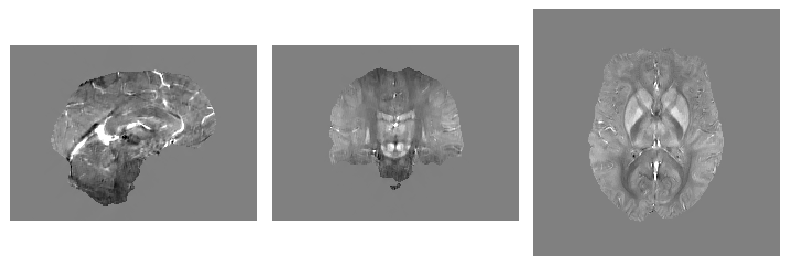

In [31]:
show_nii(glob("qsm/qsm_final/*/*.nii*")[0], cmap='gray', vmin=-0.15, vmax=+0.15, interpolation='nearest')

# Segment T1-weighted images

QSMxT doesn't just reconstruct QSM - it also assists with segmentation and quantitative analysis!

QSMxT uses FastSurfer to segment our T1-weighted images and automatically registers them to the T2*-weighted/QSM space:

In [47]:
!run_3_segment.py bids segmentations

INFO: Running QSMxT v1.3.5 (commit date: Sat Feb 25 22:06:42 2023 +1000)
INFO: Command: /opt/QSMxT/run_3_segment.py bids segmentations
INFO: Python interpreter: /opt/miniconda-4.7.12.1/bin/python3
INFO: Running with 2 processors.
230601-03:03:43,101 nipype.workflow INFO:
	 Workflow workflow_segmentation settings: ['check', 'execution', 'logging', 'monitoring']
230601-03:03:43,114 nipype.workflow INFO:
	 Running in parallel.
230601-03:03:43,205 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 4 jobs ready. Free memory (GB): 11.41/11.41, Free processors: 2/2.
230601-03:03:43,244 nipype.workflow INFO:
	 [Job 0] Cached (workflow_segmentation.sub-1.ses-1.run-01.fastsurfer_segment-t1).
230601-03:03:45,241 nipype.workflow INFO:
	 [Job 1] Cached (workflow_segmentation.sub-1.ses-1.run-01.ants_register-t1-to-qsm).
230601-03:03:47,209 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 11.41/11.41, Free processors: 2/2.
230601-03:03:47,278 nipype.workf

## View segmentations

Let's have a look at the generated `segmentations` folder:

In [33]:
!tree segmentations -L 1 --dirsfirst

segmentations
├── qsm_segmentations
├── t1_segmentations
├── workflow_segmentation
├── log_2023-06-01_00-59-06358568.txt
└── references.txt

3 directories, 2 files


We can see that we have segmentation files in both the QSM space and the T1-weighted space:

In [34]:
!tree segmentations/*segmentations

segmentations/qsm_segmentations
├── sub-1_ses-1_run-01_T1w_segmentation_nii_trans.nii
└── sub-2_ses-1_run-01_T1w_segmentation_nii_trans.nii
segmentations/t1_segmentations
├── sub-1_ses-1_run-01_T1w_segmentation_nii.nii
└── sub-2_ses-1_run-01_T1w_segmentation_nii.nii

0 directories, 4 files


Once again, we can view any relevant citations:

In [35]:
!cat segmentations/details_and_citations.txt

cat: segmentations/details_and_citations.txt: No such file or directory


# Run analysis pipeline

The final pipeline we will run is the analysis pipeline. This simply looks at each of our QSM images and associated segmentations to produce a CSV spreadsheet containing susceptibility statistics for each ROI grouped by subject:

In [36]:
!run_5_analysis.py --segmentations segmentations/qsm_segmentations/* --qsm_files qsm/qsm_final/*/*.nii* --output_dir analysis --labels_file /opt/QSMxT/aseg_labels.csv

INFO: Running QSMxT v1.3.5 (commit date: Sat Feb 25 22:06:42 2023 +1000)
INFO: Command: /opt/QSMxT/run_5_analysis.py --segmentations segmentations/qsm_segmentations/sub-1_ses-1_run-01_T1w_segmentation_nii_trans.nii segmentations/qsm_segmentations/sub-2_ses-1_run-01_T1w_segmentation_nii_trans.nii --qsm_files qsm/qsm_final/_qsmjl_rts0/sub-1_ses-1_run-01_part-phase_T2starw_scaled_romeo-combined_to-phase-wrapped_unwrapped-laplacian_freq_vsharp_rts.nii qsm/qsm_final/_qsmjl_rts0/sub-2_ses-1_run-01_part-phase_T2starw_scaled_romeo-combined_to-phase-wrapped_unwrapped-laplacian_freq_vsharp_rts.nii --output_dir analysis --labels_file /opt/QSMxT/aseg_labels.csv
INFO: Python interpreter: /opt/miniconda-4.7.12.1/bin/python3
INFO: Analysing file sub-1_ses-1_run-01_part-phase_T2starw_scaled_romeo-combined_to-phase-wrapped_unwrapped-laplacian_freq_vsharp_rts.nii with segmentation sub-1_ses-1_run-01_T1w_segmentation_nii_trans.nii
INFO: Analysing file sub-2_ses-1_run-01_part-phase_T2starw_scaled_romeo-co

Here, we view some susceptibility statistics for the left Putamen:

In [37]:
!head analysis/sub-1*csv -n 1
!cat analysis/*.csv | grep Left-Putamen

roi,num_voxels,min,max,median,mean,std
Left-Putamen,4564,-0.04625692917219098,0.14612385129488265,0.053114396344435114,0.051437584969288005,0.03213084857823438
Left-Putamen,4634,-0.06717035307025461,0.14612385129488265,0.05393306539458224,0.05242864928213682,0.031877624673682305


# Quantitative visualisation

While QSMxT produces numerical outputs, we can also use some straightforward Python to visualise some of the results.

In [38]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
# import modules
import numpy as np
import nibabel as nib
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from glob import glob

In [40]:
# define regions of interest
# see https://github.com/QSMxT/QSMxT/blob/master/aseg_labels.csv for a full list
rois = { 
    "Thalamus" : [9, 10, 48, 49],
    "Pallidum" : [12, 13, 52, 53],
    "Caudate" : [11, 50],
    "Putamen" : [12, 51],
    "Brain stem" : [16],
    "CSF" : [24, 122, 257, 701],
    "White matter" : [2, 7, 41, 46, 177]
}
roi_names = { value: key for key in rois for value in rois[key] }
roi_ids = [value for roi in rois.values() for value in roi]

In [41]:
# load a reconstruction
qsm = nib.load(glob("qsm/qsm_final/*/*.nii*")[0]).get_fdata().flatten()
seg = nib.load(glob("segmentations/qsm_segmentations/*.nii*")[0]).get_fdata().flatten()

In [42]:
# retain only the rois
qsm = qsm[np.isin(seg, roi_ids)]
seg = seg[np.isin(seg, roi_ids)]

In [43]:
# convert to a dataframe for plotting purposes
seg = pd.Series(seg).map(roi_names)
data = pd.DataFrame({ 'qsm' : qsm, 'seg' : seg })

In [44]:
print(data.groupby('seg')['qsm'].agg(['mean', 'std']).sort_values('mean').round(decimals=3))

               mean    std
seg                       
Brain stem   -0.042  0.028
White matter -0.002  0.027
Thalamus      0.028  0.033
CSF           0.029  0.096
Pallidum      0.032  0.061
Putamen       0.047  0.034
Caudate       0.049  0.024


In [45]:
medians = data.groupby('seg')['qsm'].median().sort_values()
order = medians.index

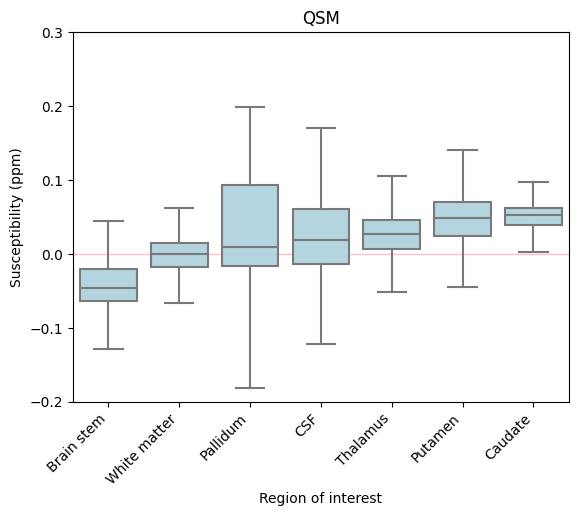

In [46]:
# plot
fig = plt.figure()
ax = sns.boxplot(data, y='qsm', x='seg', fliersize=0, color='lightblue', order=order)
ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation=45)
ax.set_ylim(-0.2, 0.3)
ax.axhline(y=0, color='pink', linestyle='-', linewidth=1, zorder=-1)
ax.set_xlabel("Region of interest")
ax.set_ylabel("Susceptibility (ppm)")
ax.set_title("QSM")
plt.show()